In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Data Normalization

### Calculate Mean and Standard Deviation

In [ ]:
# import torch
# import torchvision
# import torchvision.transforms as transforms

# Load the CIFAR-10 training dataset with ToTensor() transformation
# train_set = torchvision.datasets.CIFAR10(root='./data',
#                                          train=True,
#                                          download=True,
#                                          transform=transforms.ToTensor())

# Stacking and reshaping
# loader = torch.utils.data.DataLoader(train_set,
#                                      batch_size=len(train_set),
#                                      shuffle=False, num_workers=0)

# Extract the entire dataset from the DataLoader
# data, _ = next(iter(loader))

# # calculate mean, and sd
# mean = data.mean(dim=[0, 2, 3])
# std = data.std(dim=[0, 2, 3])

# print(f"Mean: {mean}")
# print(f"Std: {std}")

# Mean: tensor([0.4914, 0.4822, 0.4465])
# Std: tensor([0.2470, 0.2435, 0.2616])

### Normalize Data with achieved mean and sd

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:04<00:00, 41865684.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Data Labeling

In [ ]:
class BalancedFlipCIFAR10(Dataset):
    def __init__(self, cifar_dataset):
        self.cifar_dataset = cifar_dataset
        self.flip_labels = torch.randint(0, 2, (len(cifar_dataset),))

    def __len__(self):
        return len(self.cifar_dataset)

    def __getitem__(self, idx):
        image, original_label = self.cifar_dataset[idx]
        flip_label = self.flip_labels[idx]
        if flip_label == 1:
            image = transforms.functional.vflip(image)
        return image, flip_label, original_label

In [ ]:
balanced_train_dataset = BalancedFlipCIFAR10(trainset)
balanced_test_dataset = BalancedFlipCIFAR10(testset)

In [ ]:
def imshow(img, flip_label, original_label, class_names, binary_class_names):
    '''Function to display an image along with its flip status and original label.'''
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor image
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip to ensure it's a valid image
    plt.imshow(img)
    plt.title(f'Original Label: {class_names[original_label]}\nFlipped: {binary_class_names[flip_label]}')
    plt.axis('off')
    plt.show()

### Data Loading

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
binary_class_names = ['Not Flipped', 'Flipped']

balanced_train_dataset = BalancedFlipCIFAR10(trainset)
train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)

balanced_test_dataset = BalancedFlipCIFAR10(testset)
test_loader = DataLoader(balanced_test_dataset, batch_size=64, shuffle=False)
for batch in test_loader:
    print(len(batch))
    break

3


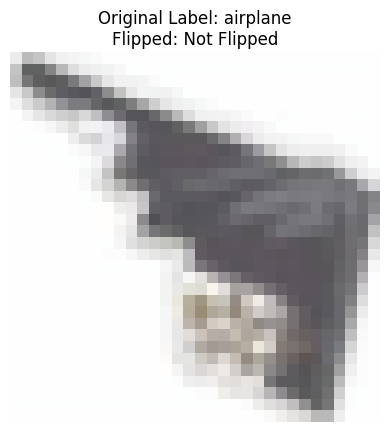

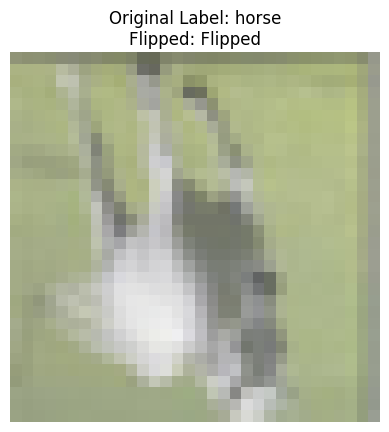

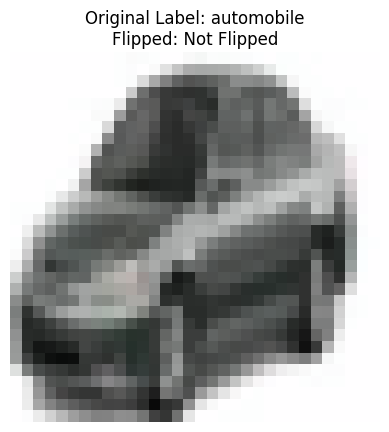

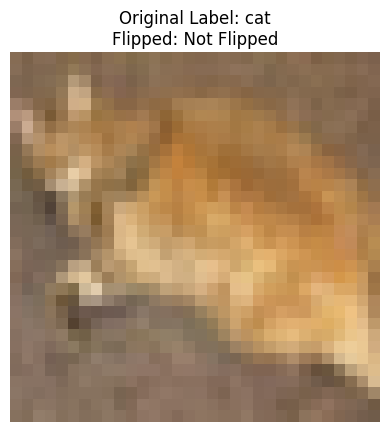

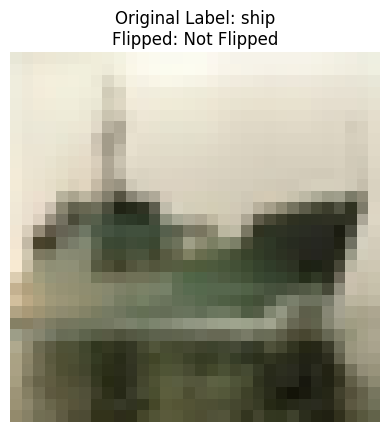

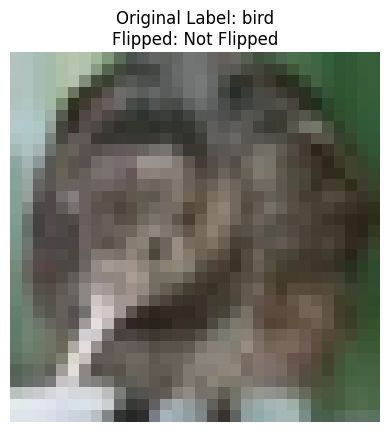

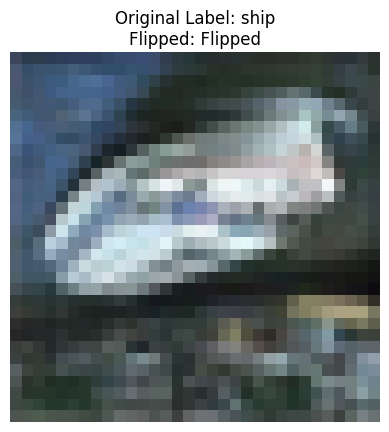

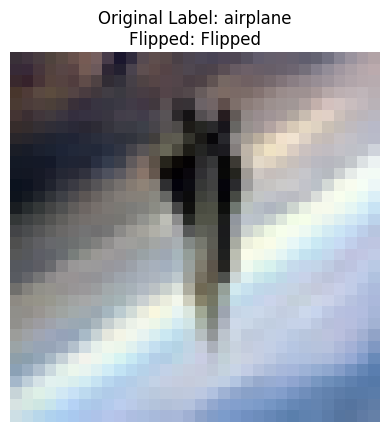

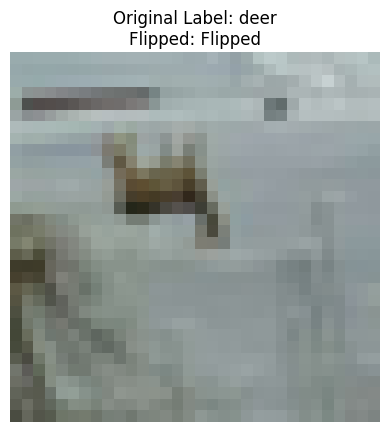

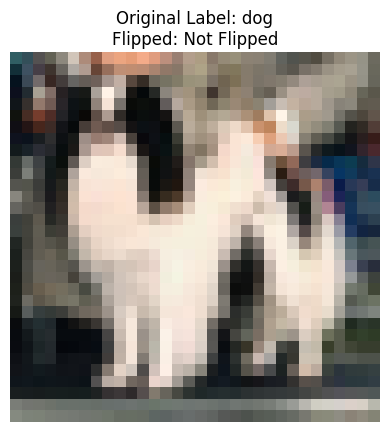

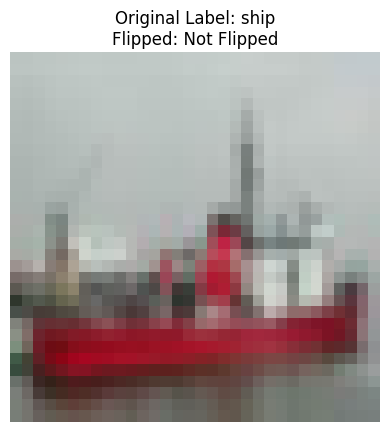

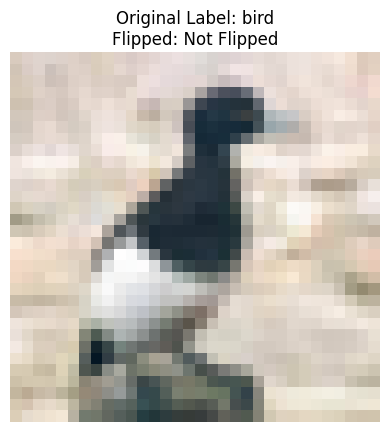

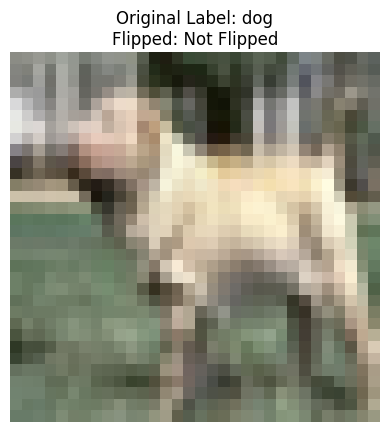

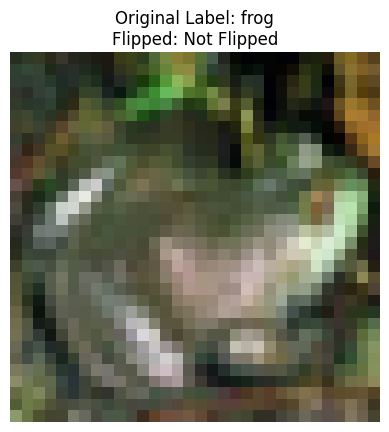

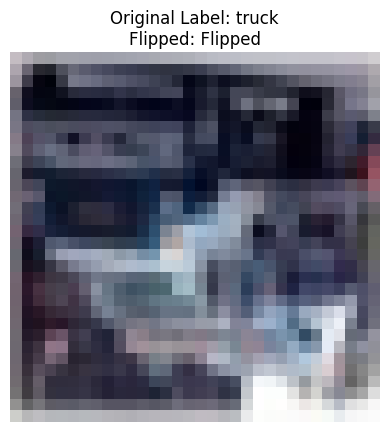

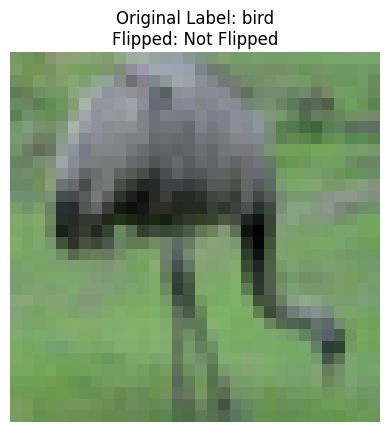

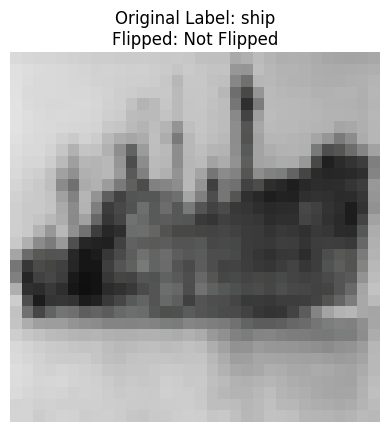

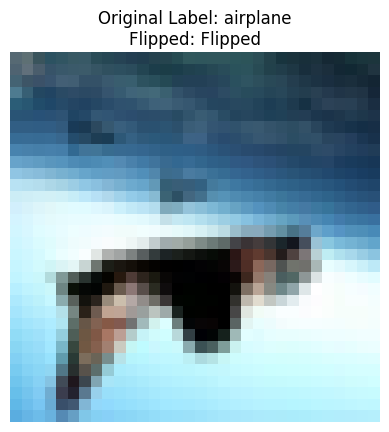

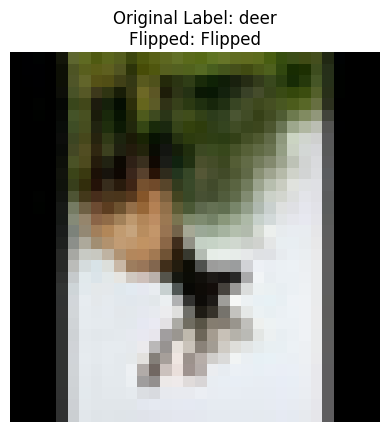

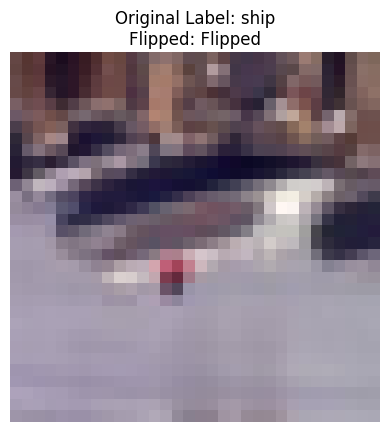

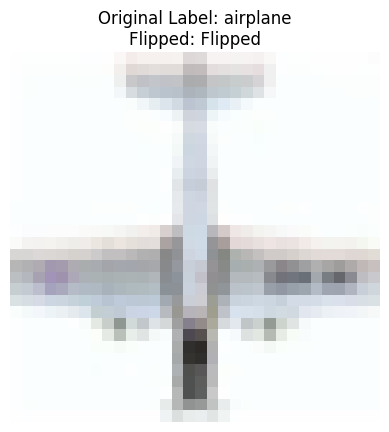

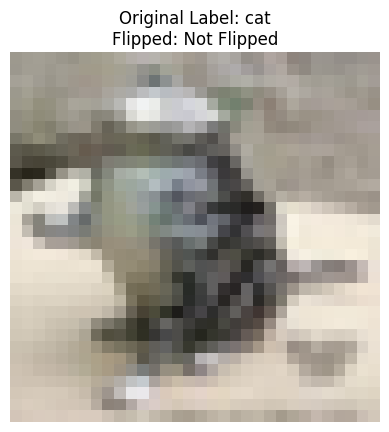

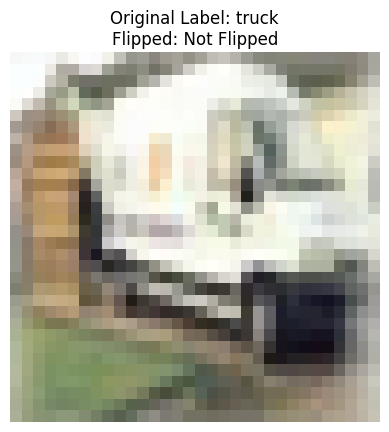

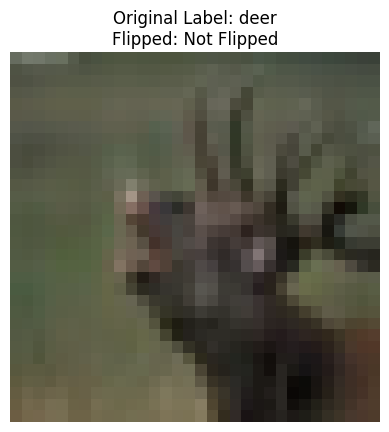

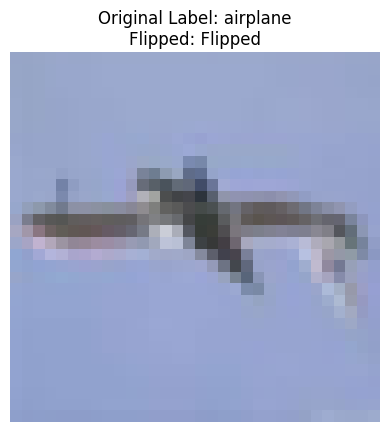

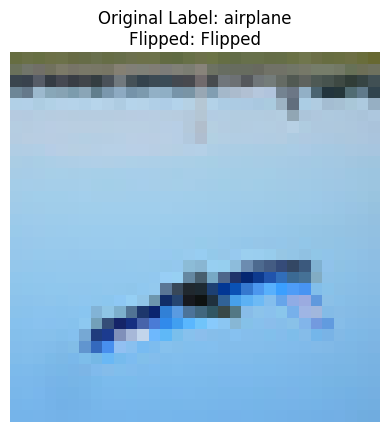

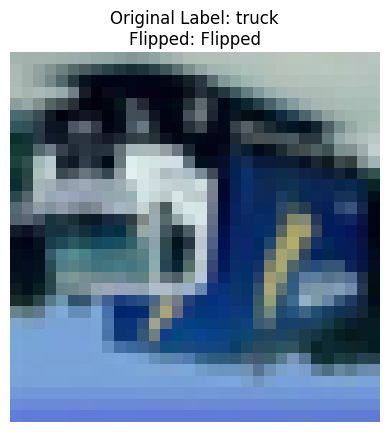

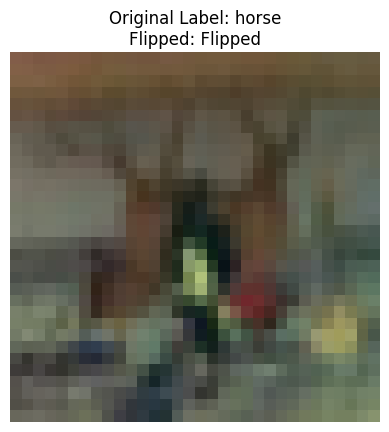

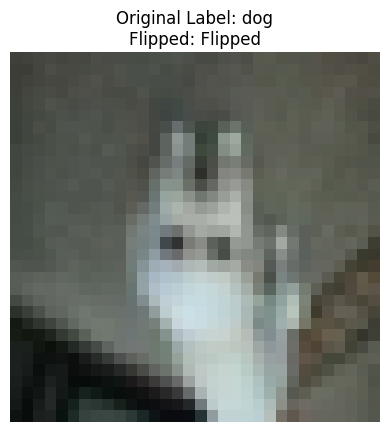

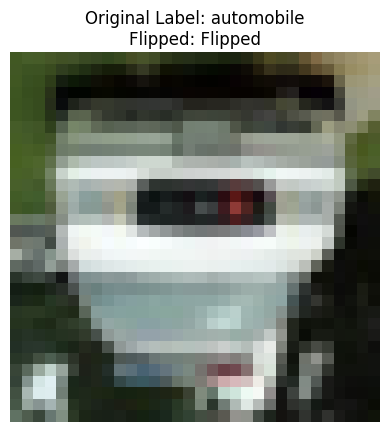

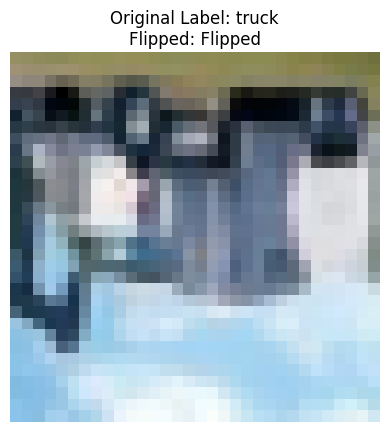

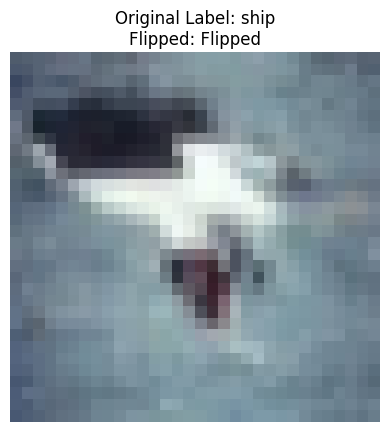

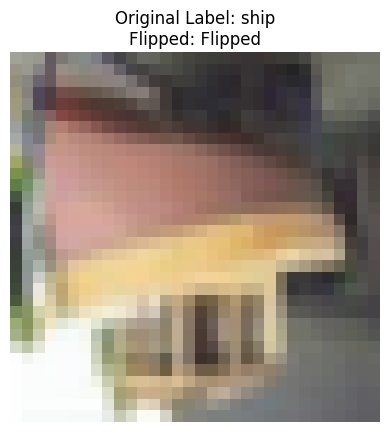

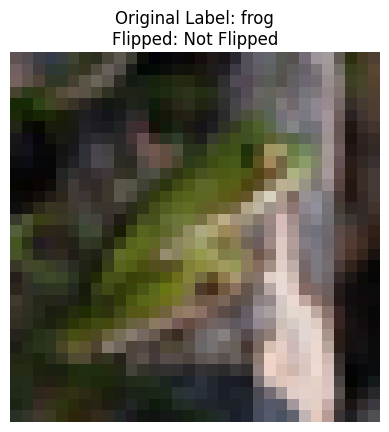

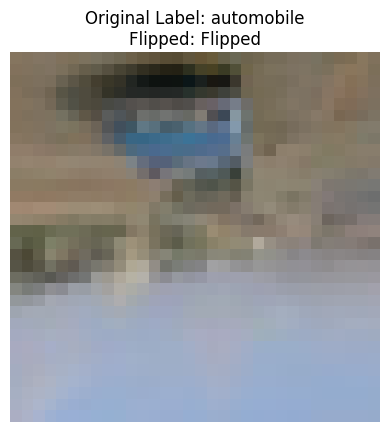

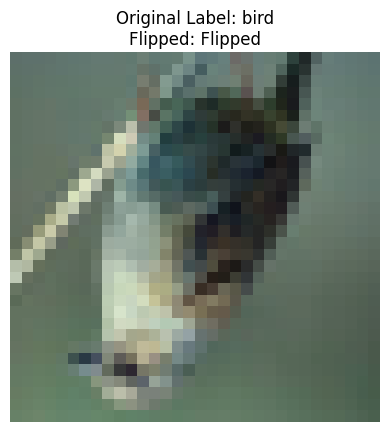

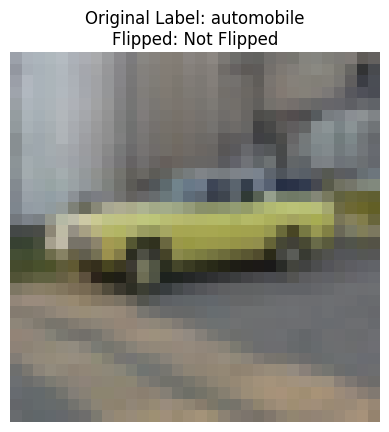

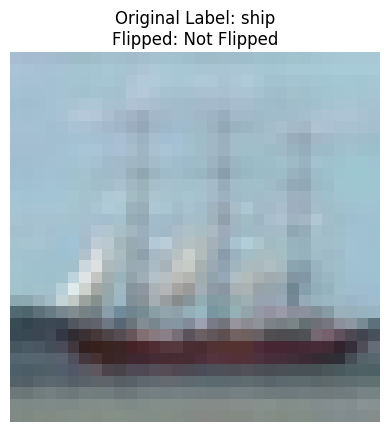

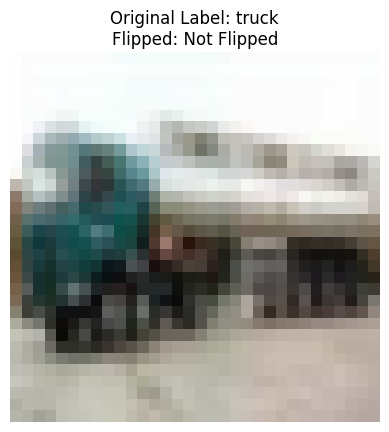

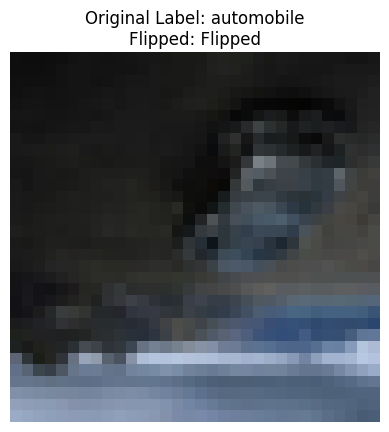

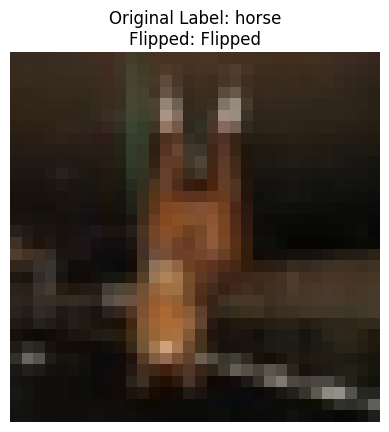

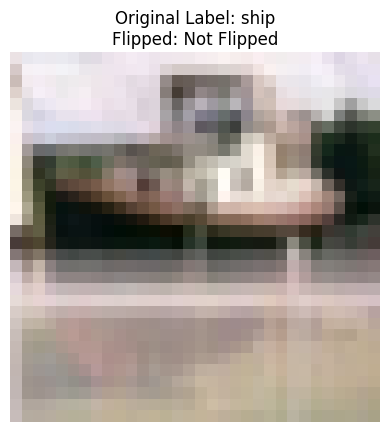

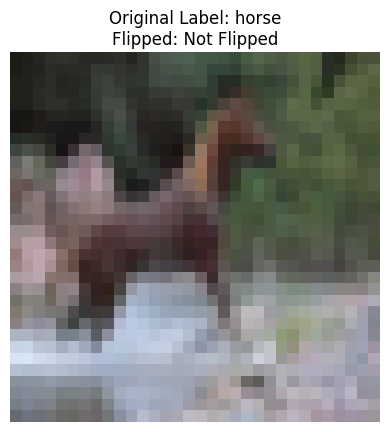

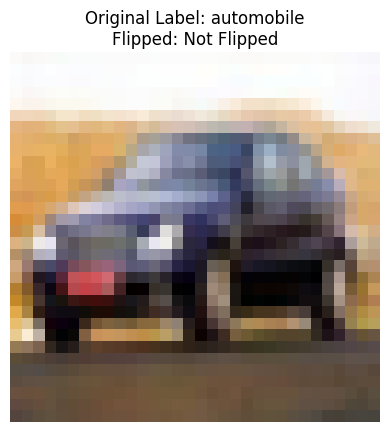

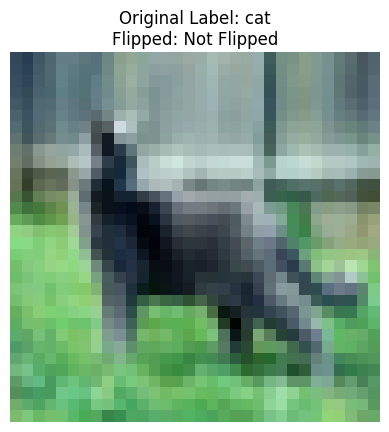

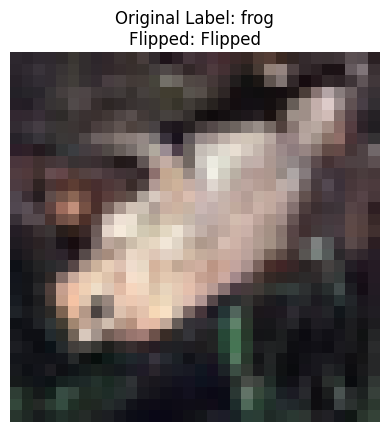

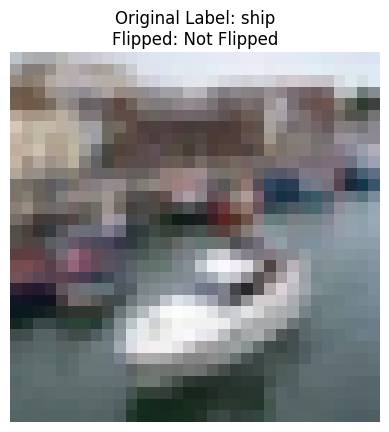

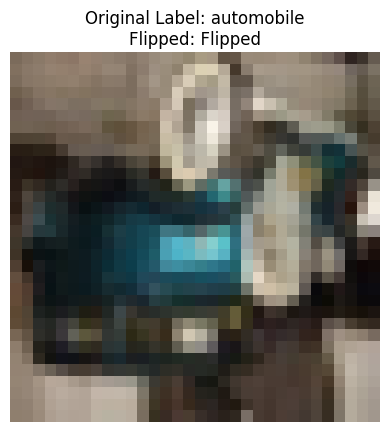

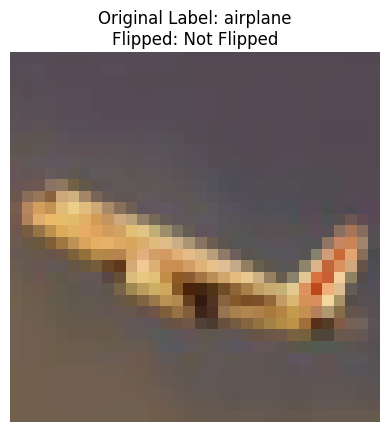

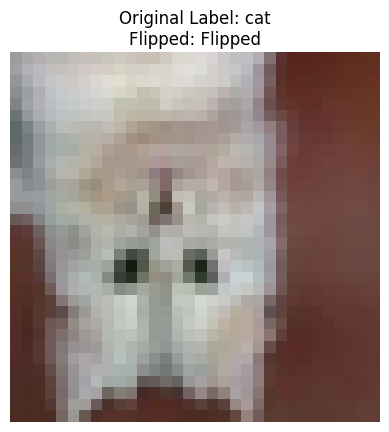

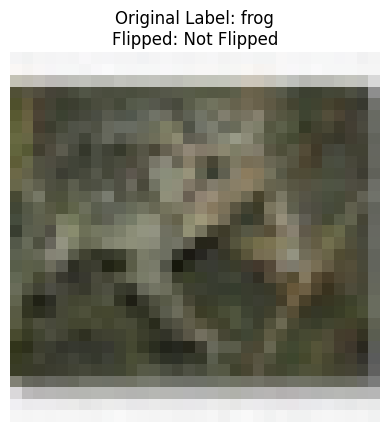

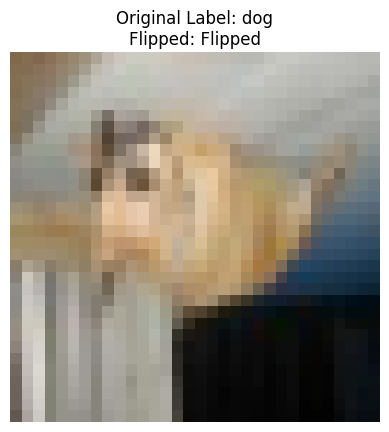

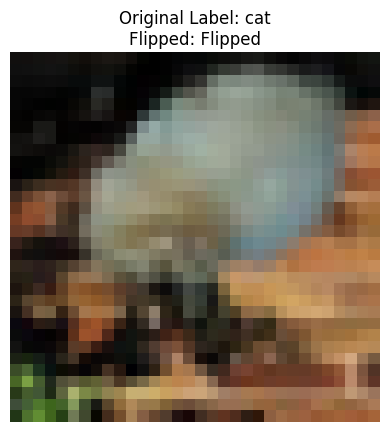

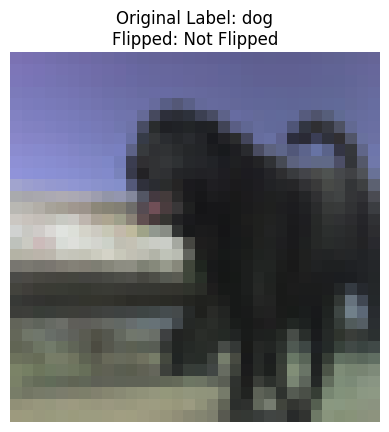

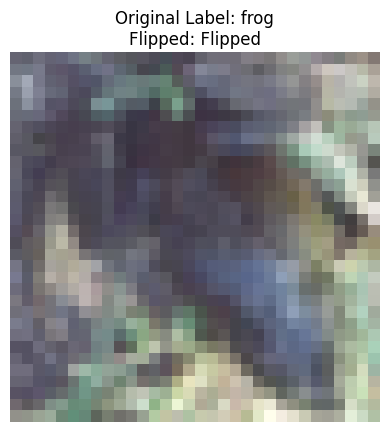

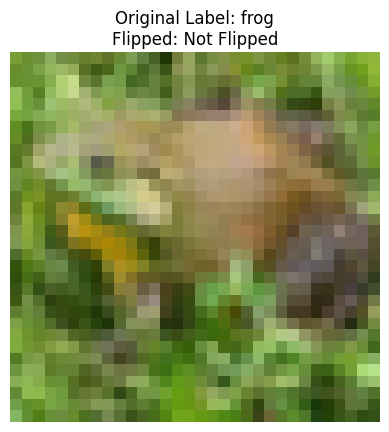

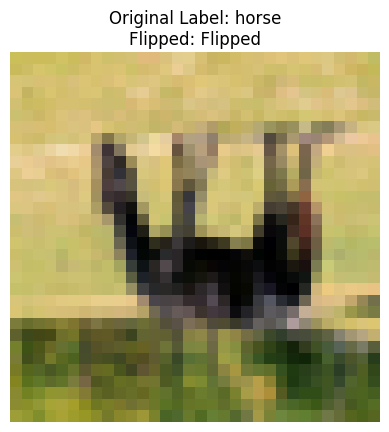

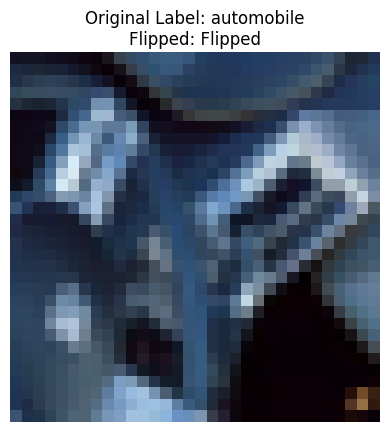

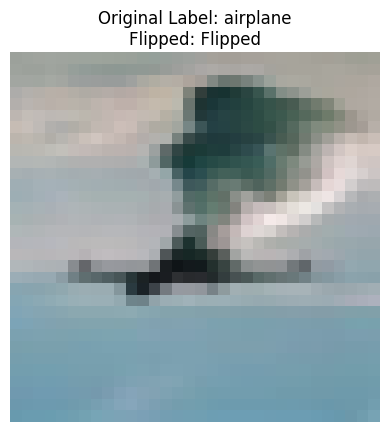

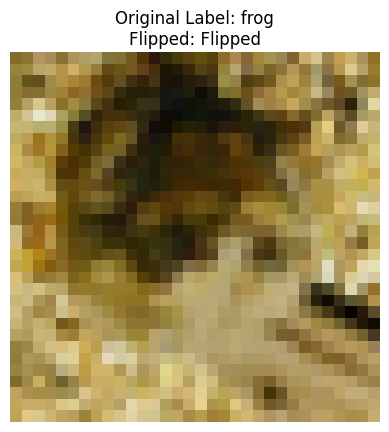

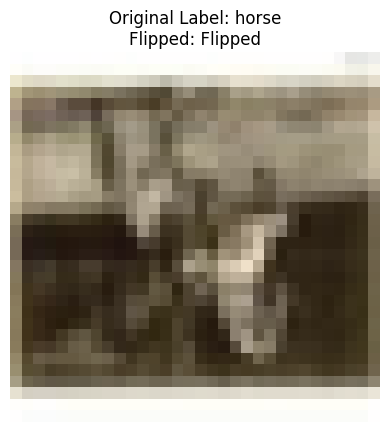

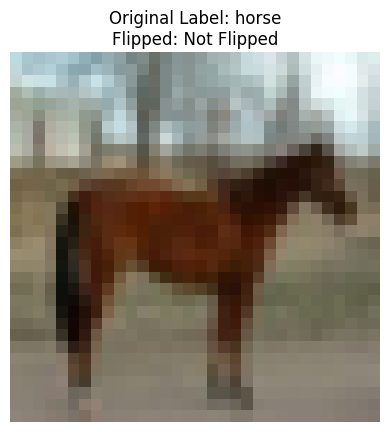

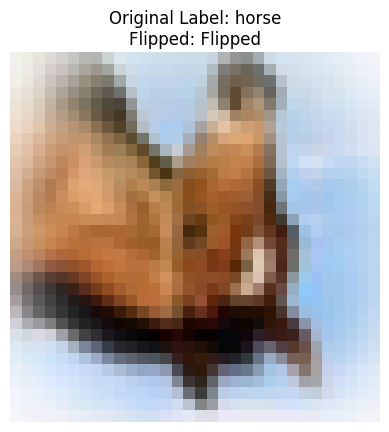

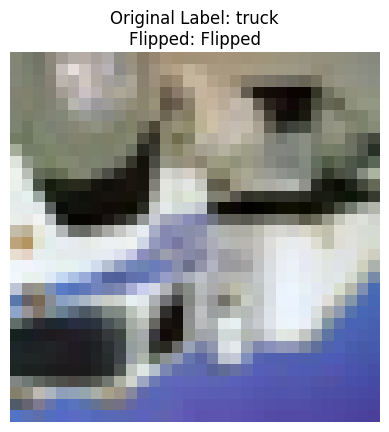

In [ ]:
def show_batch_images(dataloader):
    images, flip_labels, original_labels = next(iter(dataloader))
    for i in range(len(images)):
        imshow(images[i], flip_labels[i].item(), original_labels[i].item(), class_names, binary_class_names)

show_batch_images(train_loader)

# Model 1: ResNet18

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

model_resnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for param in model_resnet18.parameters():
    param.requires_grad = False

num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 1)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer_resnet18 = optim.SGD(model_resnet18.parameters(), lr=0.001, momentum=0.9)

## Training Function

In [ ]:
def train_model(model, criterion, optimizer, train_dataset, num_epochs=10):
    model.train()
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, flip_labels, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, flip_labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')
    print('Finished Training')


In [ ]:
train_model(model_resnet18, criterion, optimizer_resnet18, balanced_train_dataset, num_epochs=10)


Epoch 1, Loss: 0.00752139183908701
Epoch 2, Loss: 0.004953617543578148
Epoch 3, Loss: 0.0038913180029392243
Epoch 4, Loss: 0.0030067858758568763
Epoch 5, Loss: 0.0022742105039954183
Epoch 6, Loss: 0.0017798942447826266
Epoch 7, Loss: 0.00142927748369053
Epoch 8, Loss: 0.001111596397217363
Epoch 9, Loss: 0.0009349017628934235
Epoch 10, Loss: 0.0008202343305340037
Finished Training


## Save training result

In [ ]:
PATH = './cifar_resnet18.pth'
torch.save(model_resnet18.state_dict(), PATH)


## Evaluate Result

In [ ]:
model_resnet18.load_state_dict(torch.load(PATH))
model_resnet18.eval()

correct = 0
total = 0
test_loader = DataLoader(balanced_test_dataset, batch_size=64, shuffle=False)
with torch.no_grad():
    for images, flip_labels, original_labels in test_loader:
        outputs = model_resnet18(images)
        predicted = torch.round(torch.sigmoid(outputs)).squeeze()
        total += flip_labels.size(0)
        correct += (predicted == flip_labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test images: {accuracy:.2f}%')

Accuracy on the test images: 86.40%


In [ ]:
from sklearn.metrics import classification_report
import torch
import numpy as np

true_labels = []
predictions = []

model_resnet18.eval()
with torch.no_grad():
    for images, flip_labels, original_labels in test_loader:
        outputs = model_resnet18(images)
        predicted = torch.round(torch.sigmoid(outputs)).squeeze()
        true_labels.extend(flip_labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

print(classification_report(true_labels, predictions, target_names=binary_class_names))



              precision    recall  f1-score   support

 Not Flipped       0.85      0.88      0.87      5005
     Flipped       0.87      0.85      0.86      4995

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [ ]:
model_resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Find out 3 classes have the lowest accuracy

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
binary_class_names = ['Not Flipped', 'Flipped']

correct_predictions = {label: 0 for label in range(len(class_names))}
total_predictions = {label: 0 for label in range(len(class_names))}

misclassified_info = []

with torch.no_grad():
    for images, flip_labels, original_labels in test_loader:
        outputs = model_resnet18(images)
        predicted = torch.round(torch.sigmoid(outputs)).squeeze()

        for i in range(images.size(0)):
            total_predictions[original_labels[i].item()] += 1
            if predicted[i] == flip_labels[i]:
                correct_predictions[original_labels[i].item()] += 1
            else:
                misclassified_info.append((images[i], flip_labels[i], predicted[i], original_labels[i]))

class_accuracy = {class_name: correct_predictions[i] / total_predictions[i] for i, class_name in enumerate(class_names)}

lowest_accuracy_classes = sorted(class_accuracy, key=class_accuracy.get)[:3]

print("Classes with the lowest accuracy in detecting flipped/not flipped:")
for class_name in lowest_accuracy_classes:
    print(f"{class_name}: {class_accuracy[class_name]:.2%}")


Classes with the lowest accuracy in detecting flipped/not flipped:
cat: 73.10%
dog: 80.30%
bird: 80.80%


## Output 10 images from the lowest accuracy classes

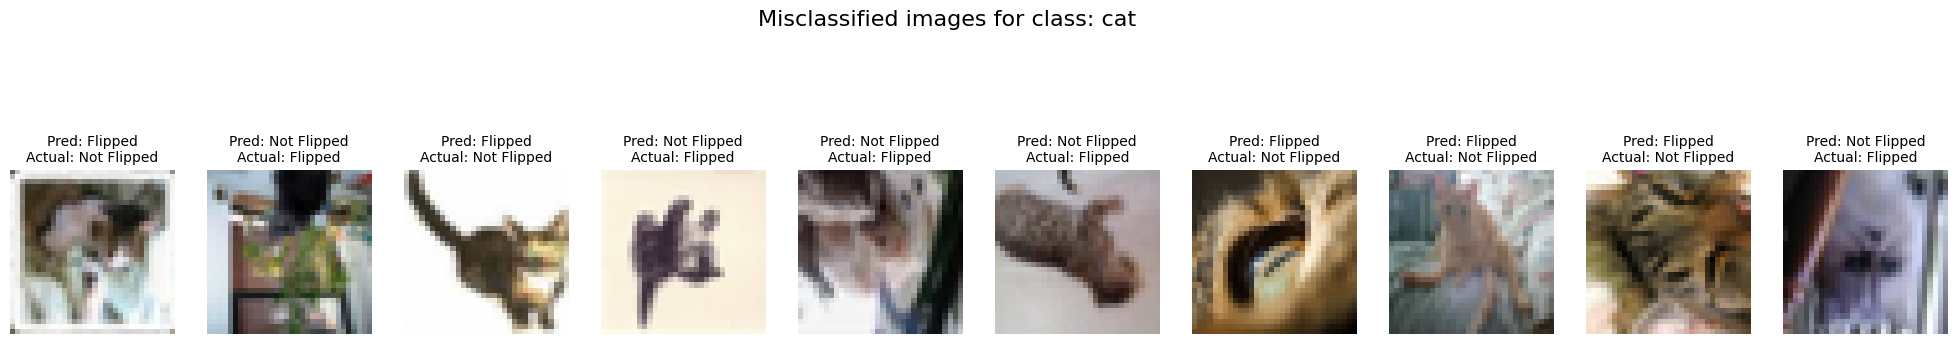

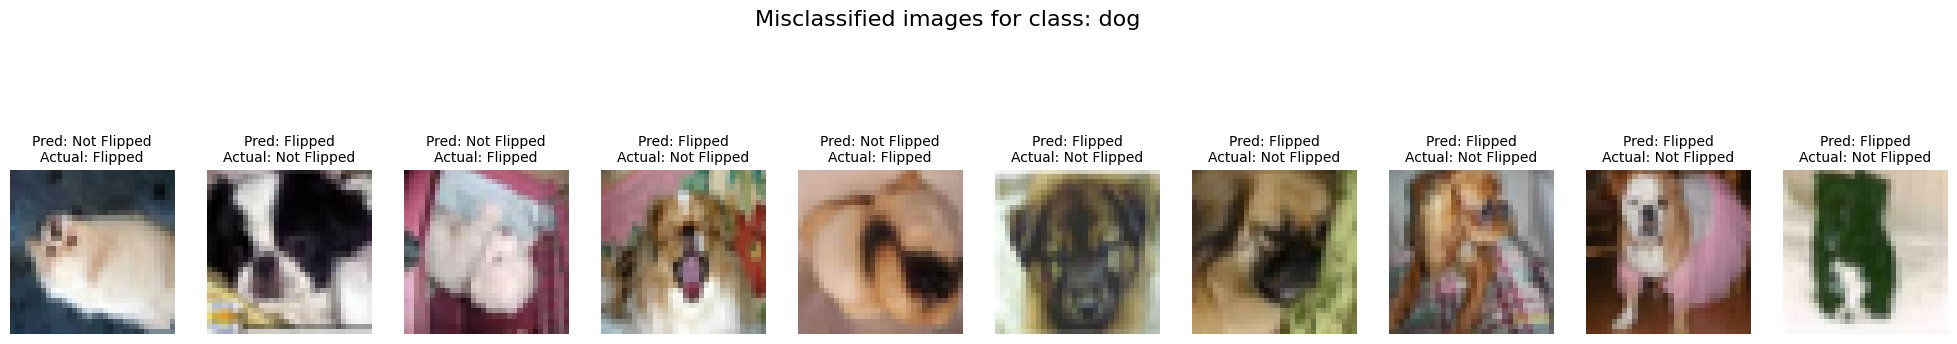

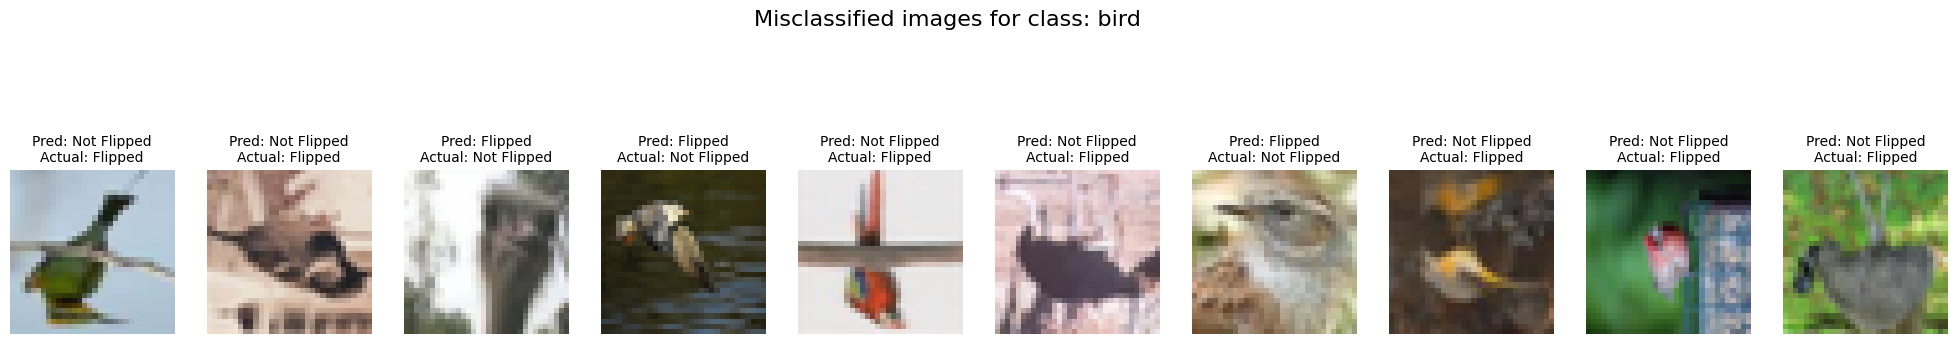

In [ ]:
import random
from collections import defaultdict

def imshow(img):
    '''Display an image.'''
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Filtered misclassified_info only for the above lowest accuracy classes
lowest_accuracy_class_indices = [class_names.index(class_name) for class_name in lowest_accuracy_classes]
filtered_misclassified_info = [info for info in misclassified_info if info[3].item() in lowest_accuracy_class_indices]

# Group misclassified images by class
misclassified_by_class = defaultdict(list)
for image, flip_status, pred_label, true_label in filtered_misclassified_info:
    misclassified_by_class[true_label.item()].append((image, flip_status, pred_label))

# Display up to 10 misclassified images for 3 classes
for class_idx in lowest_accuracy_class_indices:
    misclassified_images = misclassified_by_class[class_idx]

    # Randomly select up to 10 images from the misclassified images of this class
    selected_images = random.sample(misclassified_images, min(10, len(misclassified_images)))

    # Setting up the plot
    fig = plt.figure(figsize=(25, 5))
    plt.suptitle(f'Misclassified images for class: {class_names[class_idx]}', fontsize=16)

    for i, (image, flip_status, pred_label) in enumerate(selected_images, start=1):
        ax = fig.add_subplot(1, len(selected_images), i)  # Adjust subplot count based on the actual number of images
        imshow(image)
        ax.set_title(f'Pred: {"Flipped" if pred_label.item() == 1 else "Not Flipped"}\nActual: {"Flipped" if flip_status.item() == 1 else "Not Flipped"}', fontsize=10)
    plt.show()

## Training with other Optimizer: Adam
### with lr_scheduler to track the change in LR every epoch

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

model_resnet18Adam = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for param in model_resnet18Adam.parameters():
    param.requires_grad = False

num_ftrs = model_resnet18Adam.fc.in_features
model_resnet18Adam.fc = nn.Linear(num_ftrs, 1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s]


### Apply Adam Optimizer
#### Momentum default value is already configured as betas=(0.9, 0.999)

In [ ]:
criterion_resnet18Adam = nn.BCEWithLogitsLoss()
optimizer_resnet18Adam = optim.Adam(model_resnet18Adam.parameters(), lr=0.0005, betas=(0.9, 0.9))

### Define learning rate scheduler

In [ ]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer_resnet18Adam, step_size=1, gamma=0.1)

### Training resnet18 with Adam Optimizer

In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_dataset, num_epochs=10):
    model.train()
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, flip_labels, _ in train_loader:
            inputs, flip_labels = inputs.to(device), flip_labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, flip_labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, LR: {current_lr}')
    print('Finished Training')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet18Adam.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Train model

In [ ]:
train_model(model_resnet18Adam, criterion_resnet18Adam, optimizer_resnet18Adam, scheduler, balanced_train_dataset, num_epochs=10)

Epoch 1, Loss: 0.6432588783371479, LR: 5.000000000000009e-35
Epoch 2, Loss: 0.643876080089213, LR: 5.0000000000000094e-36
Epoch 3, Loss: 0.6443167557496854, LR: 5.00000000000001e-37
Epoch 4, Loss: 0.6433263815882261, LR: 5.00000000000001e-38
Epoch 5, Loss: 0.6426323209424762, LR: 5.00000000000001e-39
Epoch 6, Loss: 0.644397099685791, LR: 5.00000000000001e-40
Epoch 7, Loss: 0.6417649584200681, LR: 5.000000000000011e-41
Epoch 8, Loss: 0.643440639500118, LR: 5.000000000000011e-42
Epoch 9, Loss: 0.6432823506767488, LR: 5.000000000000011e-43
Epoch 10, Loss: 0.6434912720452184, LR: 5.000000000000011e-44
Finished Training


### Save result

In [ ]:
PATH1 = './cifar_resnet18Adam.pth'
torch.save(model_resnet18Adam.state_dict(), PATH1)


### Accuracy

In [ ]:
model_resnet18Adam.load_state_dict(torch.load(PATH1))
model_resnet18Adam.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet18Adam.to(device)

correct = 0
total = 0
test_loader = DataLoader(balanced_test_dataset, batch_size=64, shuffle=False)
with torch.no_grad():
    for images, flip_labels, original_labels in test_loader:

        images = images.to(device)
        flip_labels = flip_labels.to(device)

        outputs = model_resnet18Adam(images)
        predicted = torch.round(torch.sigmoid(outputs)).squeeze()
        total += flip_labels.size(0)
        correct += (predicted == flip_labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test images: {accuracy:.2f}%')

Accuracy on the test images: 61.17%
